# Test of Bayesian Markov-Chain Monte-Carlo Method with ARCS Data

This data was supplied by Garrett Granroth from the SNS / Oak Ridge National Laboratory.

The data reduction was done in Mantid, preserving events, and the events are imported from a nexus autoreduced file.  
As such, the events do have some histogram artefacts from the way that the weights are computed.
I'm not sure if this can be entirely avoided with pixelated detectors, but in an ideal world we'd compute the event weighting factors without using histograms at all.

In early versions of this notebook the weighting parameters are mis-labelled, starting with m1 instead of mElastic, and so mbg1 should be m4 and mbg2 should be mbg1, 
with mbg2 actually calculated with the simplex function provided.  Just something to be aware of in the final convergence section,
because you might think that the wrong parameters are being compared.  I'll fix that in a later commit.

/Users/phillipbentley/Code/python/mle/data/SNS/ARCS/ZrH2/IPTS-27751/nexus/201616-exported.nxs
EMAnalyser object created with 2623437 weighted events in range -661.5 - 661.5


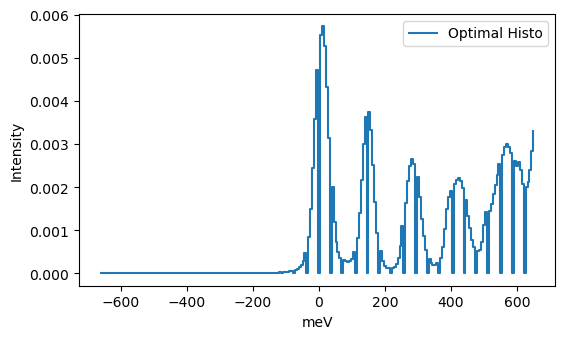

In [183]:
import h5py
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

#import warnings
#warnings.filterwarnings("error")

import lmfit 

from scipy.stats import cauchy
from scipy.stats import norm
from scipy.stats import uniform

import copy


import emtk.EventModeAnalyser.EMAnalyser as ema

# During development, this lets us change the source and force reload
# However, whilst the error reporting line number is right, the printout of
# the offending source is stuck to the first import.  Just so you know...
import importlib
importlib.reload(ema) 

def loadRawARCS(number):
    ldpath="/Users/phillipbentley/Code/python/mle/data/SNS/ARCS/ZrH2/IPTS-27751/nexus"
    stem="/ARCS_"
    tail=".nxs.h5"

    filename = ldpath + stem + str(number) + tail

    print(filename)

    f = h5py.File(filename, 'r')

    print( list(f.keys()) )

    entr = f['entry']
    b30 = entr['bank30_events']

    
    print( b30 )
    print( list(b30.keys()) )

    print(b30['event_id'])

    f.close()


def listkeys(obj):
    print( list( obj.keys()) )

def loadARCSmd(number):
    ldpath="/Users/phillipbentley/Code/python/mle/data/SNS/ARCS/ZrH2/IPTS-27751/nexus/"
    tail="-exported.nxs"

    filename = ldpath + str(number) + tail

    print(filename)

    f = h5py.File(filename, 'r')
    ws = f['MDEventWorkspace']
    cs = ws['coordinate_system']
    ed = ws['event_data']['event_data']
    bs = ws['box_structure']
    ex = ws['experiment0']
    pr = ws['process']
    vn = ws['visual_normalization']

    #for i in range(7):
    #    ed1 = ed[:,i]
    #    fig,ax = plt.subplots()
    #    plt.plot(ed1)

    dE = ed[:,6]
    wt = ed[:,0]

    #fig,ax = plt.subplots()
    #plt.plot(dE, wt)

    # Filter out zeros

    mask = wt > 0.0

    keepdE = dE[mask]
    keepwt = wt[mask]

    return keepdE, keepwt







""" We might need an integral function between two points (xmin, xmax) 
for every term in the fitting function, so that the relative likelihoods are 
normalised within the data bounds.  It will be good to check whether these
are actually needed or not in the final analysis, but in previous work
these proved to be necessary.
"""

def cauchy_integral(x1, x2, kappa):
    # Returns the integral of a cauchy distribution between two x values

    if x1 < x2:
        xmin = x1
        xmax = x2
    else:
        xmin = x2
        xmax = x1

    
    t1 = np.arctan(xmax/kappa)
    t2 = np.arctan(xmin/kappa)
    
    return (t1 - t2)/np.pi

    

def uniform_integral(x1, x2):
    # Returns the integral of a uniform distribution between two x values

    if(x1 == x2):
        return 0.0

    return np.absolute(x1-x2)



def gaussian_integral(x1, x2, mu=0.0, sigma=1.0):
    # Integral of a gaussian curve between two points
    t1 = norm.cdf(x1, loc=mu, scale=sigma)
    t2 = norm.cdf(x2, loc=mu, scale=sigma)
    intg = t1 - t2

    return np.absolute(intg)




evs, wts = loadARCSmd(201616)

ema1 = ema.EMAnalyser(evs, wts)

ema1.plot_histogram(loglog=False, log=False, xlabel='meV')



Least squares model function defined.


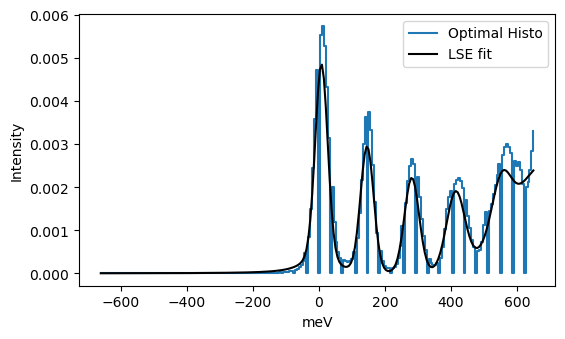

['amplitude', 'elmu', 'mu1', 'mu2', 'mu3', 'mu4', 'mubg1', 'mubg2', 'elsigma', 's1', 's2', 's3', 's4', 'sbg1', 'sbg2', 'm1', 'm2', 'm3', 'm4', 'mbg1', 'mbg2']
[1.03166976e+00 7.83319976e+00 1.45695047e+02 2.81254328e+02
 4.14035526e+02 5.52327378e+02 6.99999691e+02 2.30190791e-02
 1.86422670e+01 1.99165093e+01 2.21066916e+01 2.75136714e+01
 2.79613790e+01 1.16801601e+02 4.02817313e+01 1.90420268e-01
 1.40207127e-01 1.18191129e-01 1.18351136e-01 7.89817013e-02
 2.74781599e-01]
[4.61820689e-02 6.77407450e+00 2.42608681e+00 3.35152531e+00
 5.96478512e+00 1.22412580e+01 3.09337227e+02 3.62514381e+01
 3.89449285e+00 2.56288306e+00 3.38997008e+00 7.33200369e+00
 1.78787566e+01 5.13883390e+13 1.76492899e+02 2.18159185e-01
 1.82600064e-02 1.60267612e-02 4.38465615e-02 9.72543769e-02
 1.23466682e-01]


In [184]:
def big_lse_pdf(x, amplitude, elmu, mu1, mu2, mu3, mu4, mubg1, mubg2, elsigma, s1, s2, s3, s4, sbg1, sbg2, m1, m2, m3, m4, mbg1, mbg2):
    
    mvals = ema1.simplex_weights(np.array([m1, m2, m3, m4, mbg1, mbg2]))

    el = mvals[0] * norm.pdf(x, scale=elsigma, loc=elmu) / gaussian_integral(ema1.xmin, ema1.xmax, elsigma)

    l1 = mvals[1] * norm.pdf(x, scale=s1, loc=mu1) / gaussian_integral(ema1.xmin, ema1.xmax, mu1, s1)
    l2 = mvals[2] * norm.pdf(x, scale=s2, loc=mu2) / gaussian_integral(ema1.xmin, ema1.xmax, mu2, s2)
    l3 = mvals[3] * norm.pdf(x, scale=s3, loc=mu3) / gaussian_integral(ema1.xmin, ema1.xmax, mu3, s3)
    l4 = mvals[4] * norm.pdf(x, scale=s4, loc=mu4) / gaussian_integral(ema1.xmin, ema1.xmax, mu4, s4)
    bg1= mvals[5] * norm.pdf(x, scale=sbg1, loc=mubg1) / gaussian_integral(ema1.xmin, ema1.xmax, mubg1, sbg1)
    bg2= mvals[6] * cauchy.pdf(x, scale=sbg2, loc=mubg2) / cauchy_integral(ema1.xmin, ema1.xmax, sbg2)
    
    sol = amplitude * (el + l1 + l2 + l3 + l4 + bg1 + bg2)
    
    return sol


ema1.set_lse_function(big_lse_pdf)


ema1.make_lse_params(
    amplitude=dict(value=1.0, min=0.0),\
    elmu = dict(value=10.0, min=-100.0, max=100.0),\
    mu1 = dict(value=150.0, min=100.0, max=200.0),\
    mu2 = dict(value=280.0, min=200.0, max=350.0),\
    mu3 = dict(value=420.0, min=350.0, max=450.0),\
    mu4 = dict(value=560.0, min=500.0, max=620.0),\
    mubg1=dict(value=620.0, min=600.0, max=700.0),\
    mubg2=dict(value=140.0, min=0.0, max=200.0),\

    elsigma = dict(value=20.0, min=10.0, max=100.0),\
    s1 = dict(value=30.0, min=10.0, max=100.0),\
    s2 = dict(value=30.0, min=10.0, max=100.0),\
    s3 = dict(value=30.0, min=10.0, max=100.0),\
    s4 = dict(value=30.0, min=10.0, max=100.0),\
    sbg1=dict(value=100.0, min=100.0, max=250.0),\
    sbg2=dict(value=20.0, min=10.0, max=250.0),\
    m1=dict(value=0.3, min=0.0, max = 1.0),\
    m2=dict(value=0.2, min=0.0, max = 1.0),\
    m3=dict(value=0.15, min=0.0, max = 1.0),\
    m4=dict(value=0.1, min=0.0, max = 1.0),\
    mbg1=dict(value=0.1, min=0.0, max=1.0),\
    mbg2=dict(value=0.1, min=0.0, max=1.0)
)

lse_starting_parameters = copy.deepcopy(ema1.least_squares_parameters)

#ema1.plot_LSE_initial(loglog=False, log=False)

ema1.lse_fit()
ema1.plot_LSE_fit(loglog=False, log=False, xlabel='meV', save="/Users/phillipbentley/Code/python/mle/arcs_lse_fit.png")

pnams = ema1.get_lse_param_names()
print(pnams)

pvals = ema1.get_lse_param_values()
print(pvals)

detailed_fit_params = pvals

psigs = ema1.get_lse_param_errors()
print(psigs)

detailed_fit_sigmas = psigs

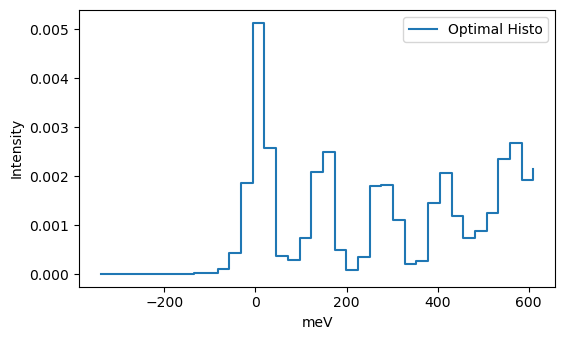

Calculating KDE
   - linear scale
nx 38
slice size 2.566666666666667


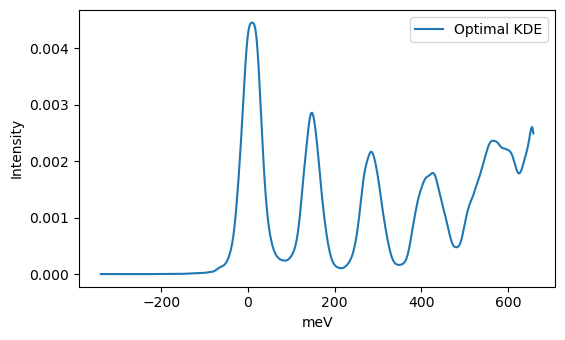

In [185]:
cpo = ema1.subsample(30000)
cpo.plot_histogram(loglog=False,log=False, xlabel='meV')
cpo.plot_kde(loglog=False,log=False, xlabel='meV', method='fdr')

In [186]:
# Build MCMC Models with API

def simplex_weights(Qraw: np.ndarray) -> np.ndarray:
    # Raw Q values can run between 0-1 to keep things simple
    # The sum is assumed to be 1, preventing out of gamut values
    # That condition is enforced already in the last 4 terms of 
    # the log_prior above.
    # Note that Qraw has one dimension fewer
    # than the number of parameters, like this:
    # https://en.m.wikipedia.org/wiki/Ternary_plot
    
    Qraw = np.asarray(Qraw)
    
    Qsum = np.sum(Qraw)    
    Qlast = 1.0 - Qsum
    
    Qvals = np.append(Qraw, Qlast)
    return Qvals

def log_prior_function(theta):
    # The main role of this function is to set 
    # parameter bounds of the bayesian search space
    elmu, mu1, mu2, mu3, mu4, mubg1, mubg2, elsigma, s1, s2, s3, s4, sbg1, sbg2, m1, m2, m3, m4, mbg1, mbg2 = theta

    if -100.0 < elmu < 100.0 and \
        100.0 < mu1  < 200.0 and \
        200.0 < mu2  < 350.0 and \
        350.0 < mu3  < 450.0 and \
        500.0 < mu4  < 620.0 and \
        600.0 < mubg1< 700.0 and \
        0.0   < mubg2< 200.0 and \
        10.0 < elsigma < 100.0 and \
        10.0 < s1 < 100.0 and \
        10.0 < s2 < 100.0 and \
        10.0 < s3 < 100.0 and \
        10.0 < s4 < 100.0 and \
        100.0 < sbg1 < 250.0 and \
        10.0  < sbg2 < 250.0 and \
        0.1 < m1 < 1.0 and\
        0.1 < m2 < 1.0 and\
        0.1 < m3 < 1.0 and\
        0.1 < m4 < 1.0 and\
        0.1 < mbg1 < 1.0 and\
        0.1 < mbg2 < 1.0 and\
        m1 + m2 + m3 + m4 + mbg1 + mbg2 < 1.0:
        return 0.0
    
    return -np.inf



def probability_mass_function(theta, xx, xmin, xmax, pweights, verbose=False):
    
    elmu, mu1, mu2, mu3, mu4, mubg1, mubg2, elsigma, s1, s2, s3, s4, sbg1, sbg2, m1, m2, m3, m4, mbg1, mbg2 = theta

    pweights = np.asarray(pweights)
    
    if (pweights==None).any():
        use_weights = np.ones_like(xx)
    else:
        use_weights = pweights

    spscale = xmax-xmin


    mvals = simplex_weights(np.array([m1, m2, m3, m4, mbg1, mbg2]))

    el = mvals[0] * norm.pdf(xx, scale=elsigma, loc=elmu) / gaussian_integral(ema1.xmin, ema1.xmax, elsigma)

    l1 = mvals[1] * norm.pdf(xx, scale=s1, loc=mu1) / gaussian_integral(ema1.xmin, ema1.xmax, mu1, s1)
    l2 = mvals[2] * norm.pdf(xx, scale=s2, loc=mu2) / gaussian_integral(ema1.xmin, ema1.xmax, mu2, s2)
    l3 = mvals[3] * norm.pdf(xx, scale=s3, loc=mu3) / gaussian_integral(ema1.xmin, ema1.xmax, mu3, s3)
    l4 = mvals[4] * norm.pdf(xx, scale=s4, loc=mu4) / gaussian_integral(ema1.xmin, ema1.xmax, mu4, s4)
    bg1= mvals[5] * norm.pdf(xx, scale=sbg1, loc=mubg1) / gaussian_integral(ema1.xmin, ema1.xmax, mubg1, sbg1)
    bg2= mvals[6] * cauchy.pdf(xx, scale=sbg2, loc=mubg2) / cauchy_integral(ema1.xmin, ema1.xmax, sbg2)

    
    sol = (el + l1 + l2 + l3 + l4 + bg1 + bg2)**use_weights
    
    return sol



def log_likelihood_function(theta, data, xmin, xmax, pweights, mylpf, verbose=False):

    raiseError = False
    result = 0.0

    elmu, mu1, mu2, mu3, mu4, mubg1, mubg2, elsigma, s1, s2, s3, s4, sbg1, sbg2, m1, m2, m3, m4, mbg1, mbg2 = theta

    pweights = np.asarray(pweights)
    
    if (pweights==None).any():
        use_weights = np.ones_like(data)
    else:
        use_weights = pweights
        
    
    lp = mylpf(theta)
    
    if np.isinf(lp):
        return -np.inf

    mvals = simplex_weights(np.array([m1, m2, m3, m4, mbg1, mbg2]))
    


    el = mvals[0] * norm.pdf(data, scale=elsigma, loc=elmu) / gaussian_integral(ema1.xmin, ema1.xmax, elsigma)
    l1 = mvals[1] * norm.pdf(data, scale=s1, loc=mu1) / gaussian_integral(ema1.xmin, ema1.xmax, mu1, s1)
    l2 = mvals[2] * norm.pdf(data, scale=s2, loc=mu2) / gaussian_integral(ema1.xmin, ema1.xmax, mu2, s2)
    l3 = mvals[3] * norm.pdf(data, scale=s3, loc=mu3) / gaussian_integral(ema1.xmin, ema1.xmax, mu3, s3)
    l4 = mvals[4] * norm.pdf(data, scale=s4, loc=mu4) / gaussian_integral(ema1.xmin, ema1.xmax, mu4, s4)
    bg1= mvals[5] * norm.pdf(data, scale=sbg1, loc=mubg1) / gaussian_integral(ema1.xmin, ema1.xmax, mubg1, sbg1)
    bg2= mvals[6] * cauchy.pdf(data, scale=sbg2, loc=mubg2) / cauchy_integral(ema1.xmin, ema1.xmax, sbg2)


    # Guard against zero values in each term
    minval = 1.0E-300

    msk = el < minval
    el[msk] = minval

    msk = l1 < minval
    l1[msk] = minval

    msk = l2 < minval
    l2[msk] = minval

    msk = l3 < minval
    l3[msk] = minval

    msk = l4 < minval
    l4[msk] = minval

    msk = bg1 < minval
    bg1[msk] = minval

    msk = bg2 < minval
    bg2[msk] = minval

    
 #   try:
    lel = np.log(el)
    ll1 = np.log(l1)
    ll2 = np.log(l2)
    ll3 = np.log(l3)
    ll4 = np.log(l4)
    lbg1 = np.log(bg1)
    lbg2 = np.log(bg2)

    lt1 = np.logaddexp(lel, ll1)
    lt2 = np.logaddexp(lt1, ll2)
    lt3 = np.logaddexp(lt2, ll3)
    lt4 = np.logaddexp(lt3, ll4)
    lt5 = np.logaddexp(lt4, lbg1)
    lt6 = np.logaddexp(lt5, lbg2)

    lll = np.sum(lt6 * use_weights)
    
    result = lp + lll

    if np.isnan(result):
        print("NaN in log_likelihood at", theta)
        verbose=True
                    
    if verbose==True:
        print("lp", lp)
        print("lll", lll)
        print("l1", l1)
        print("l2", l2)
        print("l3", l3)
        print("l4", l4)
        print("bg1", bg1)
        print("bg2", bg2)
        print("")
        print("m0", mvals[0])
        print("m1", mvals[1])
        print("m2", mvals[2])
        print("m3", mvals[3])
        print("m4", mvals[4])
        print("m5", mvals[5])
        print("m6", mvals[6])

    return result

    
#   except RuntimeWarning as e:
#        print("Runtime warning at", theta)
#        print(e)
#        raise
    


cpo.lpf = log_prior_function
cpo.pmf = probability_mass_function
cpo.llf = log_likelihood_function

# Seed MCMC search manually
# ema1.make_lse_params(
#    amplitude=dict(value=1.0, min=0.0),\
#    elmu = dict(value=10.0, min=-100.0, max=100.0),\
#    mu1 = dict(value=150.0, min=100.0, max=200.0),\
#    mu2 = dict(value=280.0, min=200.0, max=350.0),\
#    mu3 = dict(value=420.0, min=350.0, max=450.0),\
#    mu4 = dict(value=560.0, min=500.0, max=620.0),\
#    mubg1=dict(value=620.0, min=600.0, max=700.0),\
#    mubg2=dict(value=140.0, min=0.0, max=200.0),\

#    elsigma = dict(value=20.0, min=10.0, max=100.0),\
#    s1 = dict(value=30.0, min=10.0, max=100.0),\
#    s2 = dict(value=30.0, min=10.0, max=100.0),\
#    s3 = dict(value=30.0, min=10.0, max=100.0),\
#    s4 = dict(value=30.0, min=10.0, max=100.0),\
#    sbg1=dict(value=100.0, min=100.0, max=250.0),\
#    sbg2=dict(value=20.0, min=10.0, max=250.0),\
#    m1=dict(value=0.3, min=0.0, max = 1.0),\
#    m2=dict(value=0.2, min=0.0, max = 1.0),\
#    m3=dict(value=0.15, min=0.0, max = 1.0),\
#    m4=dict(value=0.1, min=0.0, max = 1.0),\
#    mbg1=dict(value=0.1, min=0.0, max=1.0),\
#    mbg2=dict(value=0.1, min=0.0, max=1.0)
#)

same_as_least_squares = np.array([10.0, 150.0, 280.0, 420.0, 560.0,\
                                 620.0, 140.0, 20.0, 30.0, 30.0,\
                                 30.0, 30.0, 100.0, 20.0,\
                                 0.3, 0.2, 0.15, 0.1, 0.1, 0.1])

#cpo.theta_seed = np.array([7.83319976e+00, 1.45695047e+02, 2.81254328e+02,\
# 4.14035526e+02, 5.52327378e+02, 6.99999691e+02, 2.30190791e-02,\
# 1.86422670e+01, 1.99165093e+01, 2.21066916e+01, 2.75136714e+01,\
# 2.79613790e+01, 1.16801601e+02, 4.02817313e+01, 1.90420268e-01,\
# 1.40207127e-01, 1.18191129e-01, 1.18351136e-01, 7.89817013e-02,\
# 2.74781599e-01])

nan_location = np.array([9.99999112e+00, 1.49999991e+02, 2.80000003e+02, 4.20000001e+02,\
 5.60000002e+02, 6.20000016e+02, 1.39999999e+02, 2.00000157e+01,\
 2.99999882e+01, 3.00000001e+01, 3.00000015e+01, 3.00000010e+01,\
 1.00000001e+02, 2.00000099e+01, 2.99987259e-01, 2.00008231e-01,\
 1.50005576e-01, 1.00000433e-01, 1.00000804e-01, 1.00002444e-01])

cpo.theta_seed = same_as_least_squares

# Seed MCMC search with LSE fit
#cpo.lse_fit()
#cpo.theta_seed = detailed_fit_params # <- this takes parameters from the detailed fit done earlier
#cpo.theta_seed = cpo.theta_seed[1:]

#log_likelihood_function(theta, data, xmin, xmax, pweights, mylpf, verbose=False)
#test=log_likelihood_function(nan_location, ema1.data, np.amin(ema1.data), np.amax(ema1.data), ema1.weights, log_prior_function, verbose=True)

cpo.nwalkers=32 # need to increase this to improve sampling stats quality 
# (see plots of MCMC_parameter_distribution later) 

cpo.MCMC_fit(nburn=20, niter=150) # fixed number of iterations
#cpo.MCMC_fit(niter=5000, convergence="Gelman-Rubin") # gelman-rubin method to check for convergence


MCMC launch
Burn in:


100%|███████████████████████████████████████████| 20/20 [00:02<00:00,  6.92it/s]


Sampling:


100%|█████████████████████████████████████████| 150/150 [00:39<00:00,  3.77it/s]

MCMC sampling complete.


In [111]:
cpo.gelman_rubin_statistic()

array([2.83686282, 2.86584667, 2.83752678, 2.88121998, 2.91269969,
       2.84436798, 2.81741003, 2.9019332 , 2.85133839, 2.79902662,
       2.73936606, 2.82148718, 2.79477057, 2.8336626 , 2.82822373,
       2.87665089, 2.81551459, 2.83197464, 2.87378398, 2.82091235])

In [112]:
print(cpo.sampler)
cpo.self_check()

True

(150, 41, 20)
(150, 41, 20)


True

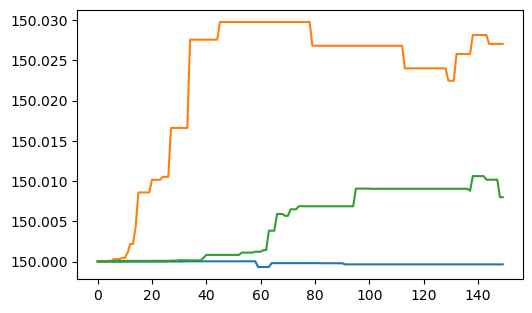

In [113]:
chz = cpo.sampler.get_chain()
nwk = cpo.nwalkers
ndm = cpo.ndim

rlen = chz.shape[0]

print(chz.shape)

burned = chz[-1000::]
#=np.delete(chz, np.s_[rlen-42:rlen], axis=0)
print(burned.shape)
ch1 = burned[:,1,1]
ch2 = burned[:,2,1]
ch3 = burned[:,3,1]
fig,ax=plt.subplots()
ax.plot(ch1)
ax.plot(ch2)
ax.plot(ch3)

cpo.self_check()

In [26]:
# The standard deviation is the square root of the variance.
# Therefore, the variance should be the standard deviation squared.

chz = cpo.sampler.get_chain()
nw = float(cpo.nwalkers)
nd = float(cpo.ndim)
ns = float(chz.shape[0])

print(chz.shape)

mns = np.mean(chz, axis=0)
print("mean shape", mns.shape)
gmn = np.mean(mns, axis=0)
print("gmn  shape", gmn.shape)


wch_variance = 1.0 / (ns - 1.0) * np.sum( (chz - mns)**2.0, axis=0)
print("wchv shape", wch_variance.shape)
wch_var_alt = np.std(chz, axis=0)**2.0
print("w alt shape", wch_var_alt.shape)


bch_variance = ns/(nw - 1.0) * np.sum( (mns - gmn)**2.0, axis=0)
print("bchv shape", bch_variance.shape)

print(bch_variance)

bch_alt_variance = np.std(mns, axis=0)**2.0
print("b alt shape", bch_alt_variance.shape)
print(bch_alt_variance)


ww = (1.0 / nw) * np.sum(wch_variance, axis=0)

wwalt = np.mean(wch_var_alt, axis=0)

print("ww shape", ww.shape)
print("wwalt sh", wwalt.shape)

print("ww", ww)
print("wwalt", wwalt)

t1 = (ns-1.0)*ww / ns
t2 = bch_variance / ns

t1alt = (ns-1.0) * wwalt / ns
t2alt = (bch_alt_variance)

print("t1 shape", t1.shape)
print("t2 shape", t2.shape)

grstat = (t1 + t2) / ww
print(grstat)

gralt = (t1alt + t2alt) / wwalt
print(gralt)


(2000, 41, 20)
mean shape (41, 20)
gmn  shape (20,)
wchv shape (41, 20)
w alt shape (41, 20)
bchv shape (20,)
[8.21028015e+03 1.04926882e+04 1.79853381e+04 1.70043310e+04
 3.10740476e+04 2.36697425e+03 2.09803430e+04 3.53294158e+03
 2.04321205e+04 9.53620405e+03 1.57160378e+04 2.53049556e+04
 3.18337870e+03 4.11122414e+03 2.81831744e+00 1.95630912e+00
 1.51854484e+00 1.41400186e+00 1.42458169e+00 2.11212566e+00]
b alt shape (20,)
[4.00501471e+00 5.11838449e+00 8.77333563e+00 8.29479559e+00
 1.51580720e+01 1.15462158e+00 1.02343137e+01 1.72338614e+00
 9.96688803e+00 4.65180685e+00 7.66635989e+00 1.23438808e+01
 1.55286766e+00 2.00547519e+00 1.37478899e-03 9.54297132e-04
 7.40753578e-04 6.89757003e-04 6.94917899e-04 1.03030520e-03]
ww shape (20,)
wwalt sh (20,)
ww [1.08260990e+01 1.12985279e+01 2.59531473e+01 2.42955498e+01
 7.37566995e+01 5.26380768e+00 3.74331843e+01 4.60618062e+00
 3.30357742e+01 1.71861061e+01 2.40167964e+01 3.25271713e+01
 5.76079207e+00 5.37421422e+00 2.04071797e-0

In [12]:
  def gsdev(mcmcObject, burn=50) -> np.ndarray :

        # Something is a bit wrong with this.
        # The statistic is starting out at a value of 2
        # in the ARCS test notebook and gently increasing
        # It should not be behaving in this way, there is obviously
        # a mistake in the maths below...

        chains = mcmcObject.sampler.get_chain(discard=burn)
            
        nwk = mcmcObject.nwalkers # "J"
        ndm = mcmcObject.ndim
        nsamps = chains.shape[0] #"L"

        chain_mean = np.mean(chains, axis=0)        
        grand_mean = np.mean(chain_mean, axis=0)

        within_chain_variance = 1.0 / (nsamps - 1.0) * np.sum( (chains - grand_mean)**2.0, axis=0)
        between_chain_variance = nsamps/(nwk - 1.0) * np.sum( (chain_mean - grand_mean)**2.0, axis=0)
        
        ww = (1.0 / nwk) * np.sum(within_chain_variance, axis=0)
        
        t1 = (nsamps-1.0)*ww / nsamps
        t2 = between_chain_variance / nsamps
        
        grstat = (t1 + t2) / ww
        
        return grstat

gs0 = gsdev(cpo, burn=0)
gs10 = gsdev(cpo, burn=10)
gs50 = gsdev(cpo, burn=50)
gs100= gsdev(cpo, burn=100)
gs150= gsdev(cpo, burn=150)

print(gs0)
print(gs10)
print(gs50)
print(gs100)
print(gs150)

[1.25952132 1.29204014 1.30711615 1.31011463 1.15693305 1.17382589
 1.26304146 1.2844474  1.3968396  1.33000028 1.33235707 1.12329778
 1.17443442 1.20010264 1.26635603 1.26102338 1.30225416 1.35450943
 1.30047127 1.22637419]
[1.26056568 1.29321932 1.30848602 1.3112593  1.15780142 1.17483287
 1.26437034 1.28587928 1.39859657 1.33145977 1.33365427 1.12391322
 1.17537533 1.20102022 1.27044939 1.26554263 1.30389002 1.35748019
 1.30282704 1.22984944]
[1.26483065 1.29803228 1.31408915 1.31592389 1.1613735  1.17898021
 1.2698227  1.291751   1.40578268 1.33742711 1.33894463 1.1264374
 1.1792415  1.20477639 1.28750748 1.28553068 1.31054567 1.36914862
 1.31209095 1.24463767]
[1.27036526 1.30426622 1.32136943 1.3219574  1.16607725 1.18444863
 1.27695854 1.29939511 1.41513665 1.34519455 1.34578057 1.12973759
 1.18431461 1.20967818 1.30447775 1.31323401 1.31847832 1.37961511
 1.32059985 1.26350658]
[1.27612257 1.31080232 1.32898801 1.32820666 1.17107343 1.19026078
 1.28447518 1.30732512 1.42491098 

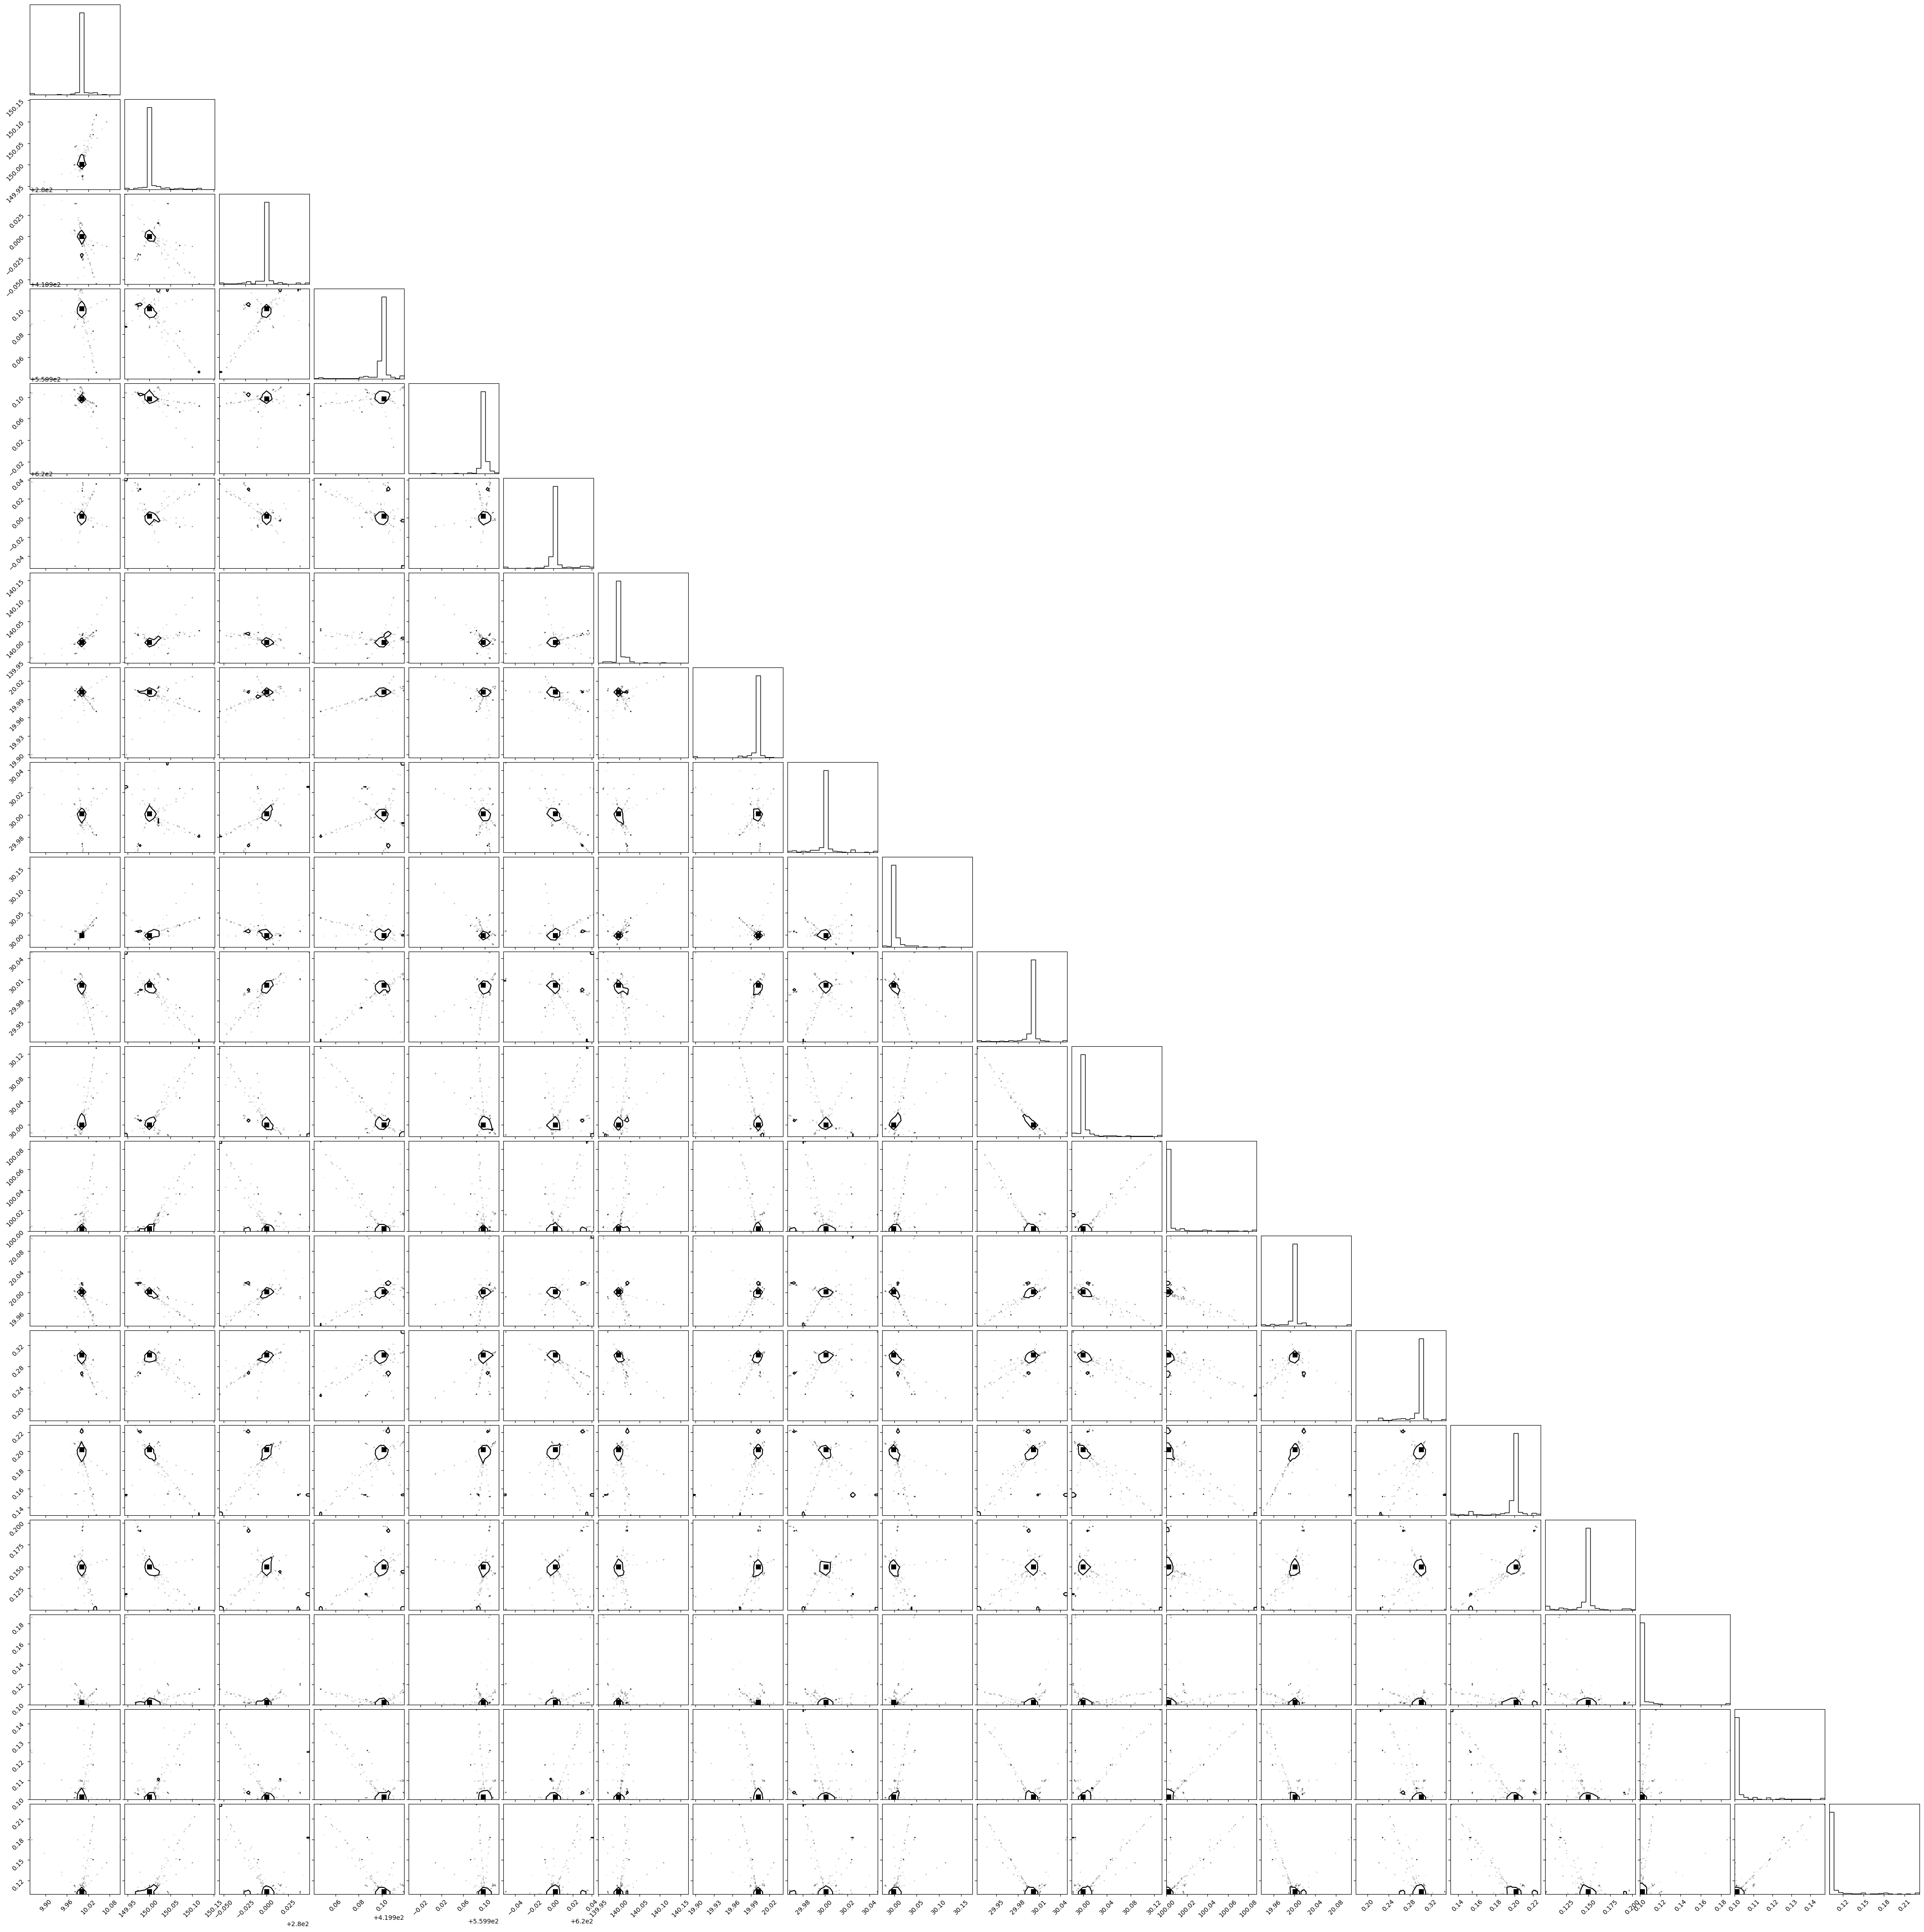

In [100]:
import corner

fff = corner.corner(
    cpo.sampler.get_chain(flat=True))


Calculating KDE
   - linear scale
nx 38
slice size 2.566666666666667


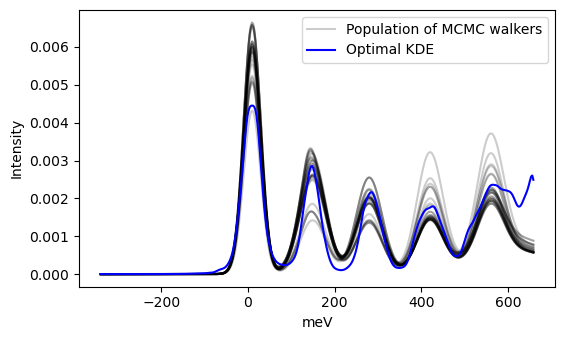

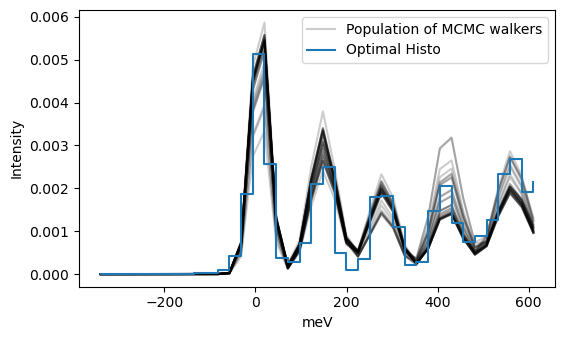

In [188]:
#cpo.plot_LSE_fit(loglog=False, log=False, xlabel='meV')
#cpo.plot_MCMC_fit(method="histo", loglog=False, log=False, xlabel='meV', save="arcs_mcmc_fit.png")

cpo.self_check()

cpo.plot_MCMC_fit(method='kde', loglog=False, log=False, xlabel='meV')
cpo.plot_MCMC_fit(method='histo', loglog=False, log=False, xlabel='meV')

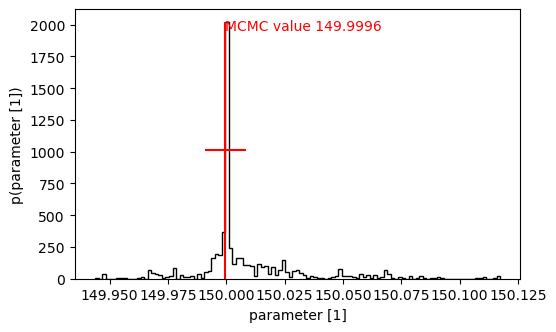

In [193]:
lookat=1
#cpo.plot_MCMC_parameter_distribution(lookat, compare=True)
cpo.plot_MCMC_parameter_distribution(lookat, compare=False, method='peak')

In [190]:
print("PEAK METHOD:")
mcpparams, mcperr = cpo.get_MCMC_parameters(method='peak')
print(mcparams)
print(mcerr)

print()
print("MEAN METHOD:")
mcparams, mcerr = cpo.get_MCMC_parameters(method='mean')
print(mcparams)
print(mcerr)

print()
print("LSE on full data set")
lsparams = ema1.get_lse_param_values()


lserrors = ema1.get_lse_param_errors()
print(lsparams)
print(lserrors)

import pandas

pn = ema1.get_lse_param_names()
pn = pn[1:]

df = pandas.DataFrame({"PARAMETER": pn, "LSE": lsparams[1:], "LSE_ERR": lserrors[1:], "BAYES": mcparams, "BAYES_ERR": mcerr, "BAYES-PEAK": mcpparams, "BAYES-PEAK-ERR": mcperr})
print(df)

PEAK METHOD:
[1.00925038e+01 1.49822666e+02 2.80046931e+02 4.19971529e+02
 5.60078470e+02 6.20145114e+02 1.39911158e+02 2.01364771e+01
 3.00102786e+01 2.99897382e+01 2.99149113e+01 2.99821330e+01
 1.00077702e+02 1.99543614e+01 2.30858604e-01 1.61250090e-01
 1.24893535e-01 1.34889314e-01 1.46917383e-01 1.38764786e-01]
[0.00333765 0.00432623 0.00265287 0.00168131 0.0024865  0.00826885
 0.00205064 0.00933826 0.0010872  0.00171934 0.00313698 0.00209772
 0.00080604 0.00204856 0.00043112 0.00035625 0.00019532 0.00029242
 0.0003314  0.00027222]

MEAN METHOD:
[1.00024803e+01 1.50008187e+02 2.80007840e+02 4.19990562e+02
 5.60004596e+02 6.19977171e+02 1.40009223e+02 1.99824828e+01
 2.99976097e+01 3.00057809e+01 3.00004733e+01 2.99904224e+01
 1.00009284e+02 1.99858256e+01 2.95348899e-01 1.96990879e-01
 1.45772523e-01 1.12547952e-01 1.13737479e-01 1.06009348e-01]
[0.00024744 0.00029941 0.00022914 0.00047142 0.00068931 0.00042786
 0.00036236 0.00043962 0.0001983  0.00058897 0.0002005  0.00049599
 0

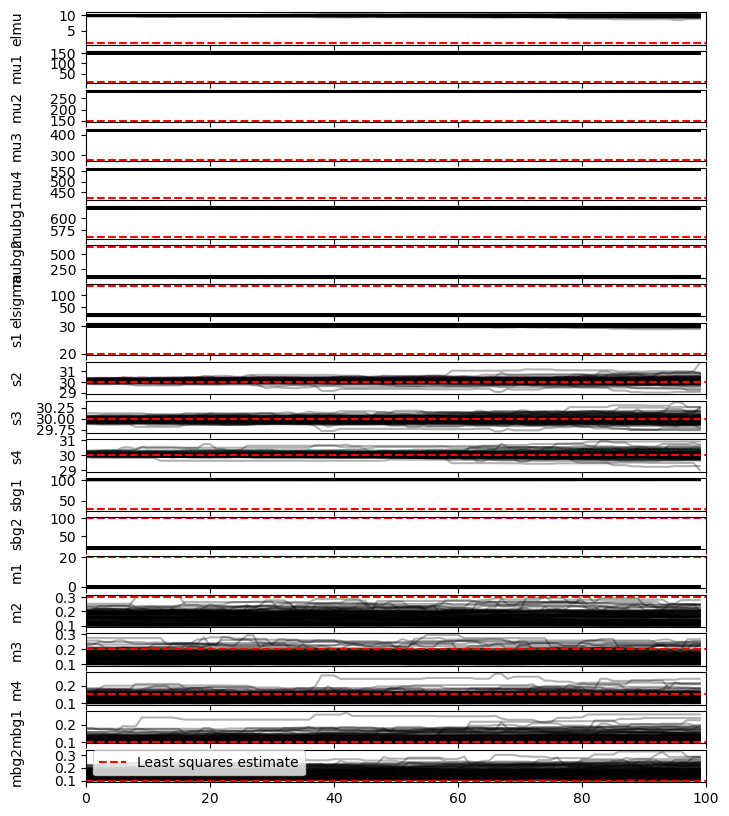

In [31]:
cpo.plot_MCMC_convergences()

## Event-dependent convergence study

In [54]:
assumed_param_values = np.copy(mcparams)

maxsiz = np.log10(evs.size)
print(evs.size)
print(maxsiz)
evreps=10
n_evs = np.logspace(2, maxsiz, evreps).astype(int)
print(n_evs)
n_evs[-1]=evs.size
print(n_evs)

lse_results = np.zeros((evreps, mcparams.size+1))
lse_errors  = np.zeros((evreps, mcparams.size+1))
mcmc_results = np.zeros((evreps, mcparams.size))
mcmc_errors = np.zeros((evreps, mcparams.size))


lsMinEvents = 10000
mcmcMinEvents = 10
lsMaxEvents = 10000000
mcmcMaxEvents = 90000


rep = 0

for nn in n_evs:
    print("Rep", rep+1, "/", evreps, "|", nn, "/", evs.size)
    print("Subsampling...")
    sse = ema1.subsample(nn)

    sse.lpf = log_prior_function
    sse.pmf = probability_mass_function
    sse.llf = log_likelihood_function


    if nn >= lsMinEvents and nn <= lsMaxEvents:
        print("Least Squares Analysis...")
        sse.least_squares_parameters = copy.deepcopy(lse_starting_parameters)
        sse.calculate_histogram()
        sse.lse_fit()
        #sse.plot_LSE_fit(loglog=False, log=False, xlabel='meV')


        lse_results[rep,:] = sse.get_lse_param_values()
        lse_errors[rep,:] = sse.get_lse_param_errors()
    else:
        print("Skipping Least Squares Analysis (too few events for stable fit)")

    if nn >= mcmcMinEvents and nn <= mcmcMaxEvents:
        print("MCMC Analysis...")
        sse.nwalkers=128 # need to increase this to improve sampling stats quality 
        # (on plots of MCMC_parameter_distribution) 

        sse.theta_seed = same_as_least_squares
        sse.MCMC_fit(niter=200)

        mcmc_results[rep,:], mcmc_errors[rep,:] = sse.get_MCMC_parameters(method='peak')
    else:
        print("Skipping MCMC Analysis (too many events to run on a laptop in sensible time)")

    rep = rep + 1

print("Convergence loop complete.")

2623437
6.418870639382126
[    100     309     959    2971    9203   28505   88290  273463  847003
 2623436]
[    100     309     959    2971    9203   28505   88290  273463  847003
 2623437]
Rep 1 / 10 | 100 / 2623437
Subsampling...
Skipping Least Squares Analysis (too few events for stable fit)
MCMC Analysis...
MCMC launch
Burn in:


100%|█████████████████████████████████████████| 100/100 [00:06<00:00, 15.08it/s]


Sampling:


100%|█████████████████████████████████████████| 200/200 [00:13<00:00, 15.34it/s]


MCMC sampling complete.
Rep 2 / 10 | 309 / 2623437
Subsampling...
Skipping Least Squares Analysis (too few events for stable fit)
MCMC Analysis...
MCMC launch
Burn in:


100%|█████████████████████████████████████████| 100/100 [00:07<00:00, 13.33it/s]


Sampling:


100%|█████████████████████████████████████████| 200/200 [00:13<00:00, 15.00it/s]


MCMC sampling complete.
Rep 3 / 10 | 959 / 2623437
Subsampling...
Skipping Least Squares Analysis (too few events for stable fit)
MCMC Analysis...
MCMC launch
Burn in:


100%|█████████████████████████████████████████| 100/100 [00:08<00:00, 12.07it/s]


Sampling:


100%|█████████████████████████████████████████| 200/200 [00:16<00:00, 12.30it/s]


MCMC sampling complete.
Rep 4 / 10 | 2971 / 2623437
Subsampling...
Skipping Least Squares Analysis (too few events for stable fit)
MCMC Analysis...
MCMC launch
Burn in:


100%|█████████████████████████████████████████| 100/100 [00:13<00:00,  7.48it/s]


Sampling:


100%|█████████████████████████████████████████| 200/200 [00:25<00:00,  7.95it/s]


MCMC sampling complete.
Rep 5 / 10 | 9203 / 2623437
Subsampling...
Skipping Least Squares Analysis (too few events for stable fit)
MCMC Analysis...
MCMC launch
Burn in:


100%|█████████████████████████████████████████| 100/100 [00:28<00:00,  3.45it/s]


Sampling:


100%|█████████████████████████████████████████| 200/200 [00:55<00:00,  3.61it/s]


MCMC sampling complete.
Rep 6 / 10 | 28505 / 2623437
Subsampling...
Least Squares Analysis...
MCMC Analysis...
MCMC launch
Burn in:


100%|█████████████████████████████████████████| 100/100 [01:10<00:00,  1.41it/s]


Sampling:


100%|█████████████████████████████████████████| 200/200 [02:21<00:00,  1.42it/s]


MCMC sampling complete.
Rep 7 / 10 | 88290 / 2623437
Subsampling...
Least Squares Analysis...
MCMC Analysis...
MCMC launch
Burn in:


100%|█████████████████████████████████████████| 100/100 [03:39<00:00,  2.20s/it]


Sampling:


100%|█████████████████████████████████████████| 200/200 [07:44<00:00,  2.32s/it]


MCMC sampling complete.
Rep 8 / 10 | 273463 / 2623437
Subsampling...
Least Squares Analysis...
Skipping MCMC Analysis (too many events to run on a laptop in sensible time)
Rep 9 / 10 | 847003 / 2623437
Subsampling...
Least Squares Analysis...
Skipping MCMC Analysis (too many events to run on a laptop in sensible time)
Rep 10 / 10 | 2623437 / 2623437
Subsampling...
Subsample will return a direct copy of the data instead.
Least Squares Analysis...
Skipping MCMC Analysis (too many events to run on a laptop in sensible time)
Convergence loop complete.


In [55]:
def p_conv_plot(item, Bayes=True, LSE=True):

    # Least squares parameters
    pnams = sse.get_lse_param_names()
    pnam = pnams[item+1]
    
    lsnevs = n_evs
    lsvalues = lse_results[:,item+1]
    lserrs = lse_errors[:,item+1]

    lsmask = lsvalues != 0.0
    lsnevs = lsnevs[lsmask]
    lsvalues = lsvalues[lsmask]
    lserrs = lserrs[lsmask]
    
    lsbtop = lsvalues+lserrs
    lsbbot = lsvalues-lserrs
    lswtop = np.amax(lsvalues)
    lswbot = np.amin(lsvalues)

    # Bayesian parameters
    mcnevs = n_evs
    mcvalues = mcmc_results[:,item]
    mcerrs = mcmc_errors[:,item]

    mcmask = mcvalues != 0.0
    mcvalues = mcvalues[mcmask]
    mcerrs = mcerrs[mcmask]
    mcnevs = mcnevs[mcmask]
    
    
    mcbtop = mcvalues+mcerrs
    mcbbot = mcvalues-mcerrs
    mcwtop = np.amax(mcvalues)
    mcwbot = np.amin(mcvalues)
    
    
    wtop = np.amax([lswtop, mcwtop])
    wbot = np.amin([lswbot, mcwbot])

    wspan = wtop - wbot
    wpad = wspan * 0.1
    wtop = wtop + np.abs(wpad)
    wbot = wbot - np.abs(wpad)

        
    fig, ax = plt.subplots()
    if LSE:
        ax.plot(lsnevs, lsvalues, color='blue', label='LSE')
        ax.fill_between(lsnevs, lsbbot, lsbtop, color='blue', alpha=0.15, label='LSE $\sigma$')
        ax.set_ylim([wbot, wtop])
        ax.set_xlabel("# events")
        ax.set_ylabel(pnam + "Value")    

    if Bayes:
        ax.plot(mcnevs, mcvalues, color='red', label='Bayes')
        ax.fill_between(mcnevs, mcbbot, mcbtop, color='red', alpha=0.15, label='Bayes $\sigma$')
    
    plt.xscale('log')
    ax.legend()
    
    #print(sse.get_lse_param_names())

    

### Elastic Line Parameters

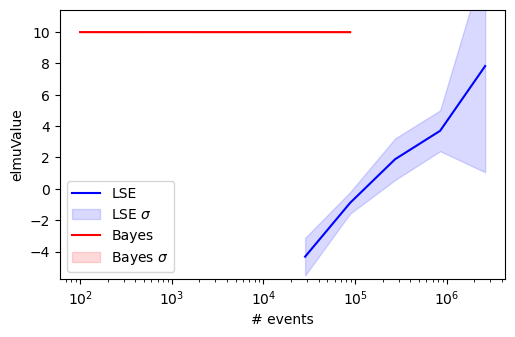

In [56]:
parameter_no = 0
p_conv_plot(parameter_no)
#p_conv_plot(parameter_no, LSE=False)

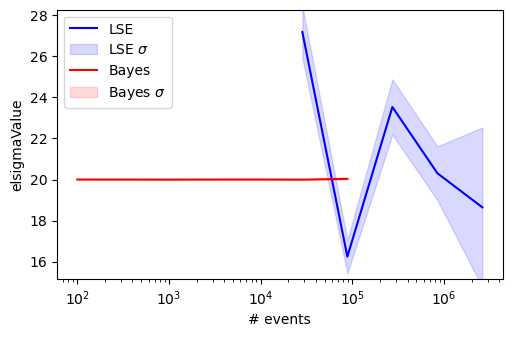

In [57]:
parameter_no = 7
p_conv_plot(parameter_no)
#p_conv_plot(parameter_no, LSE=False)

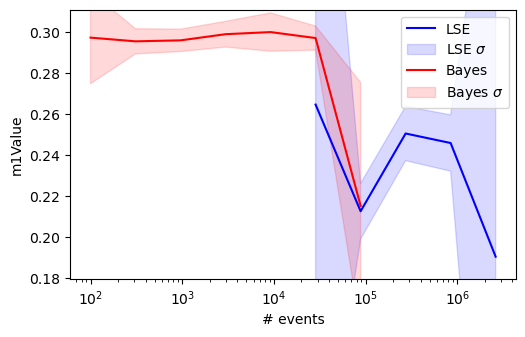

In [58]:
parameter_no = 14
p_conv_plot(parameter_no)
#p_conv_plot(parameter_no, LSE=False)

### First Excitation Line Parameters

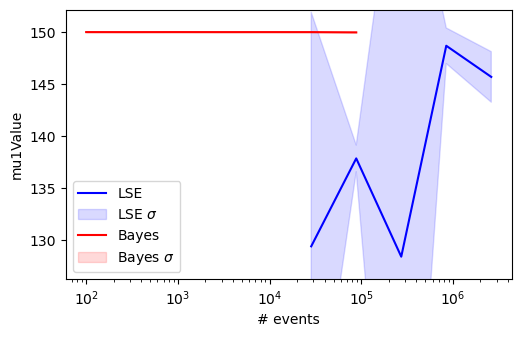

In [59]:
parameter_no = 1
p_conv_plot(parameter_no)
#p_conv_plot(parameter_no, LSE=False)

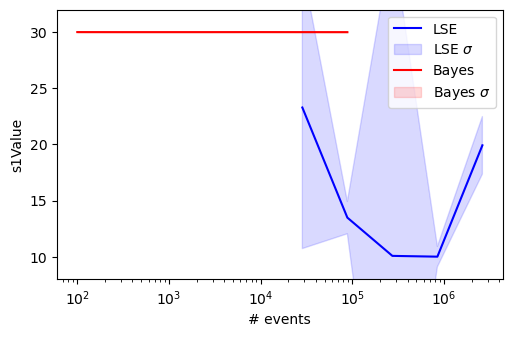

In [60]:
parameter_no = 8
p_conv_plot(parameter_no)
#p_conv_plot(parameter_no, LSE=False)

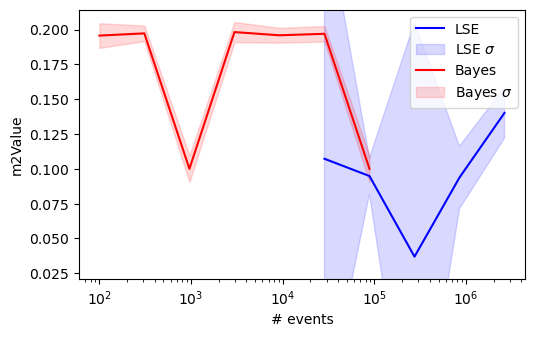

In [61]:
parameter_no = 15
p_conv_plot(parameter_no)
#p_conv_plot(parameter_no, LSE=False)

### Second Excitation Line Parameters

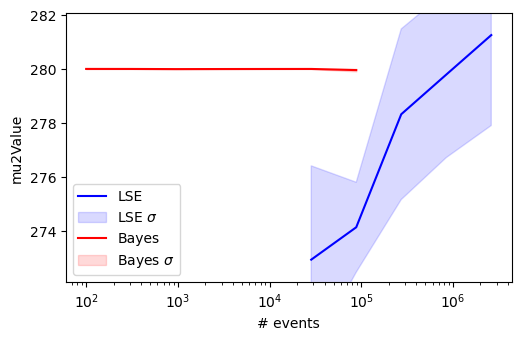

In [62]:
parameter_no = 2
p_conv_plot(parameter_no)
#p_conv_plot(parameter_no, LSE=False)

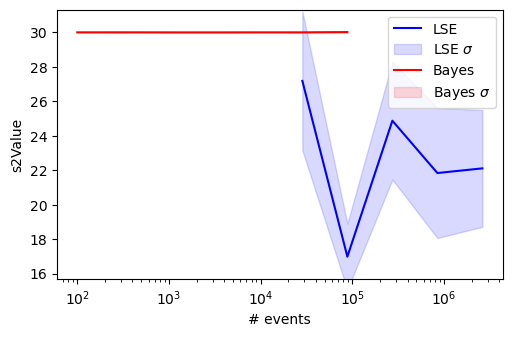

In [63]:
parameter_no = 9
p_conv_plot(parameter_no)
#p_conv_plot(parameter_no, LSE=False)

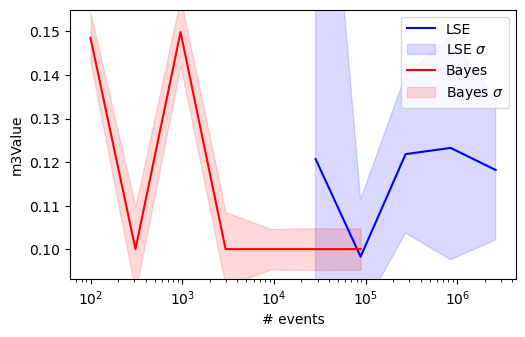

In [64]:
parameter_no = 16
p_conv_plot(parameter_no)
#p_conv_plot(parameter_no, LSE=False)

### Third Excitation Line Parameters

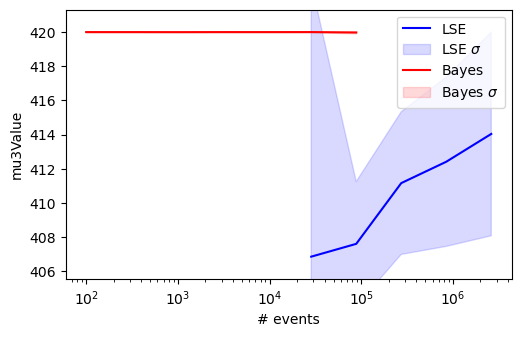

In [65]:
parameter_no = 3
p_conv_plot(parameter_no)
#p_conv_plot(parameter_no, LSE=False)

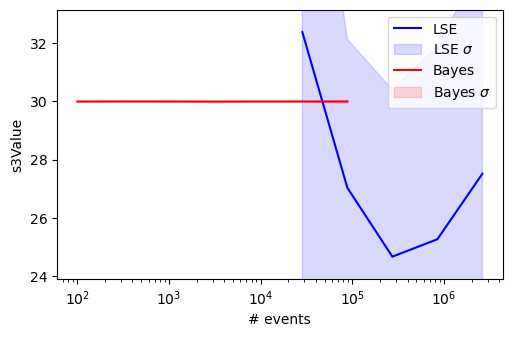

In [66]:
parameter_no = 10
p_conv_plot(parameter_no)
#p_conv_plot(parameter_no, LSE=False)

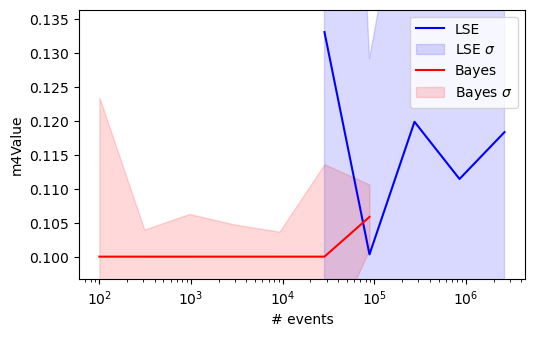

In [67]:
parameter_no = 17
p_conv_plot(parameter_no)
#p_conv_plot(parameter_no, LSE=False)

### Fourth Excitation Line Parameters

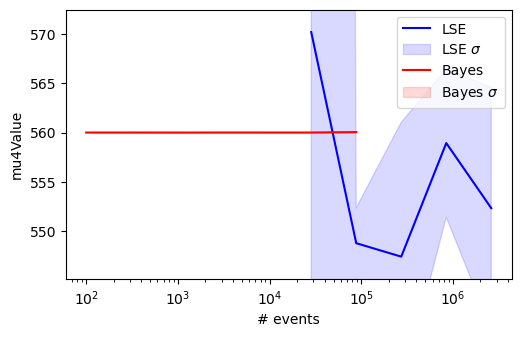

In [68]:
parameter_no = 4
p_conv_plot(parameter_no)
#p_conv_plot(parameter_no, LSE=False)

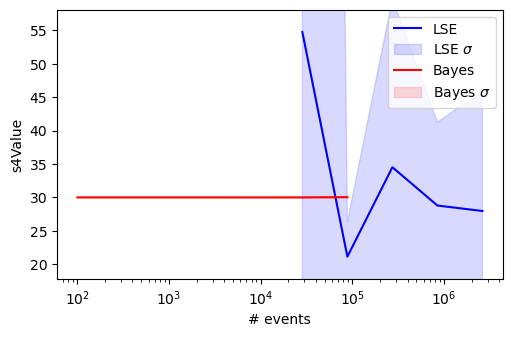

In [69]:
parameter_no = 11
p_conv_plot(parameter_no)
#p_conv_plot(parameter_no, LSE=False)

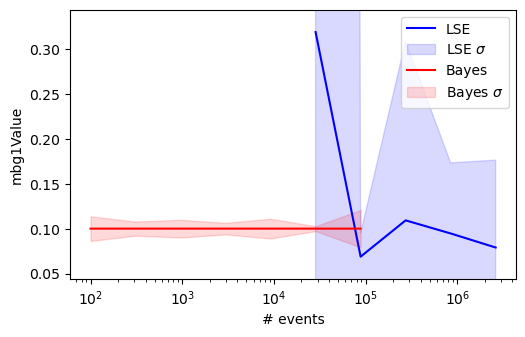

In [70]:
parameter_no = 18
p_conv_plot(parameter_no)
#p_conv_plot(parameter_no, LSE=False)

### First Background Term Parameters 

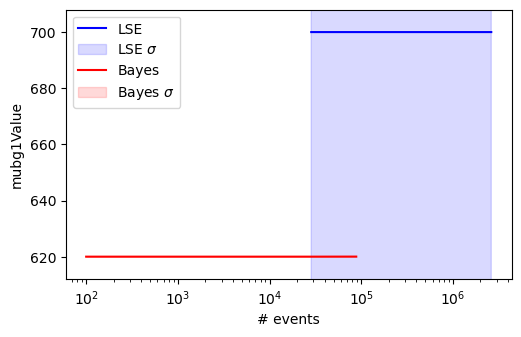

In [71]:
parameter_no = 5
p_conv_plot(parameter_no)
#p_conv_plot(parameter_no, LSE=False)

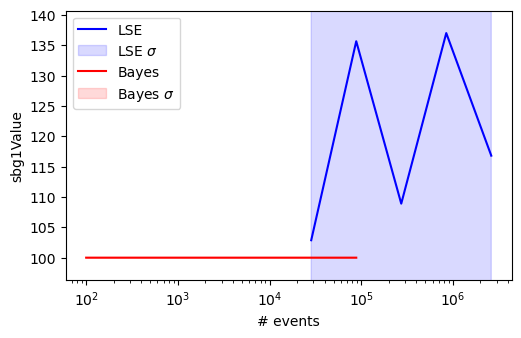

In [72]:
parameter_no = 12
p_conv_plot(parameter_no)
#p_conv_plot(parameter_no, LSE=False)

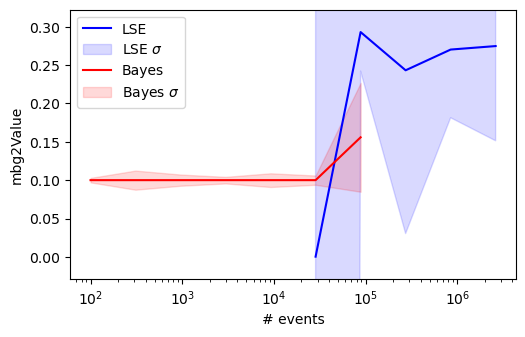

In [73]:
parameter_no = 19
p_conv_plot(parameter_no)
#p_conv_plot(parameter_no, LSE=False)

### Second Background Term Parameters

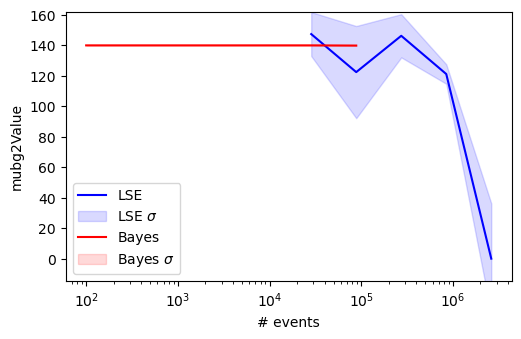

In [74]:
parameter_no = 6
p_conv_plot(parameter_no)
#p_conv_plot(parameter_no, LSE=False)

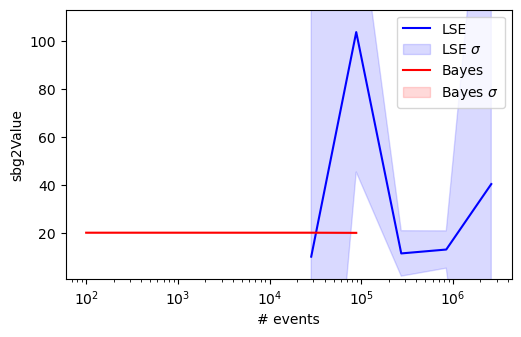

In [75]:
parameter_no = 13
p_conv_plot(parameter_no)
#p_conv_plot(parameter_no, LSE=False)

The weight of the second background term is computed from 1-sum(other_weights) so it has no individual parameter.

## Important Questions and Possible Answers

1. Why does the parameter noise obviously exceed the reported variance for the MCMC parameters?

Probably because the random subsample of events is at each step random.  The variance is the *statistical* variance as sampled by MCMC within the data set, whilst the subsampling of the events for low numbers of events provides a systematic shift of that parameter space from analysis to analysis.  The correct variance would probably be obtained by re-subsampling many times and computing the mean and standar deviation of the obtained parameters.  This is going to be very slow and would require a cluster job in the future to do that work.

2. Why does the variance on some LSE parameters increase with increasing events?

Probably because the LSE is unstable with so many parameters, and it is getting stuck in a local optimum.  If you look at some of the parameters the stated variances for these parameters are enormous, so the LSE estimates from the chi-squared surface curvature are probably wrong.  Since many of the parameter values are so close to those obtained from MCMC I suspect that monte-carlo sampling the LSE parameter space as described above might yield more realistic parameter variances.
